# Library

In [1]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set Params

In [13]:
batch_size = 64
epochs = 5
latent_dim = 128
# latent_dim = 256
num_samples = 10000

# Load data

In [3]:
data_path = './data/fra-eng/fra.txt'
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [4]:
len(lines)

178010

# Vectorize the data

In [5]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
for line in lines[:min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use \t to start sequence and \n as end sequence for the character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
            
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for input:', max_encoder_seq_length)
print('Max sequence length for output:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for input: 15
Max sequence length for output: 59


In [6]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t+1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']]  = 1.
    decoder_input_data[i, t, target_token_index[' ']]  = 1.

# Model Fitting

In [7]:
def Seq2Seq_fit_drop(dropouts):
    stacks = []
    for dropout in dropouts:
        # Define an input sequence and pross it

        encoder_inputs = Input(shape=(None, num_encoder_tokens))
        encoder = LSTM(latent_dim, return_state=True, dropout=dropout)
        encoder_outputs, state_h, state_c = encoder(encoder_inputs)
        encoder_states = [state_h, state_c]

        # Setup Decoder

        decoder_inputs = Input(shape=(None, num_decoder_tokens))
        decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout)
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
        decoder_dense = Dense(num_decoder_tokens, activation='softmax')
        decoder_outputs = decoder_dense(decoder_outputs)

        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

        stack = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, \
                         batch_size=batch_size,\
                         epochs=epochs,\
                         validation_split=0.2)
        model.save(f"s2s-dropout{dropout}.h5")
        stacks.append(stack)
    return stacks

In [8]:
def Seq2Seq_fit():
    # Define an input sequence and pross it

    encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = LSTM(latent_dim, return_state=True, dropout=0.2, recurrent_dropout=0.2,)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]

    # Setup Decoder

    decoder_inputs = Input(shape=(None, num_decoder_tokens))
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.summary
#     stack = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, \
#                      batch_size=batch_size,\
#                      epochs=epochs,\
#                      validation_split=0.2)
#     model.save(f"s2s-dropout{dropout}.h5")
#     return stack

In [9]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True, dropout=0.2, recurrent_dropout=0.2,)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Setup Decoder

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm[0][1]            

In [14]:
# Define an input sequence and pross it

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True, dropout=0.2, recurrent_dropout=0.2,)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Setup Decoder

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
attn_layer = Attention()([encoder_outputs, decoder_outputs])
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_layer])

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

stack = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, \
                 batch_size=batch_size,\
                 epochs=epochs,\
                 validation_split=0.2)
model.save(f"s2s-dropout{dropout}.h5")
return stack

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 128), (None, 102400      input_7[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, None, 128),  113664      input_8[0][0]                    
                                                                 lstm_6[0][1]          

ValueError: in user code:

    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/keras/layers/merge.py:183 call
        return self._merge_function(inputs)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/keras/layers/merge.py:522 _merge_function
        return K.concatenate(inputs, axis=self.axis)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:2881 concatenate
        return array_ops.concat([to_dense(x) for x in tensors], axis)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:1654 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/ops/gen_array_ops.py:1221 concat_v2
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3477 _create_op_internal
        ret = Operation(
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/brunolw/.pyenv/versions/3.8.5/envs/wordvec/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimension 1 in both shapes must be equal, but are 59 and 64. Shapes are [64,59] and [64,64]. for '{{node functional_7/concat_layer/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](functional_7/lstm_7/transpose_1, functional_7/attention_2/MatMul_1, functional_7/concat_layer/concat/axis)' with input shapes: [64,59,128], [64,64,128], [] and with computed input tensors: input[2] = <2>.


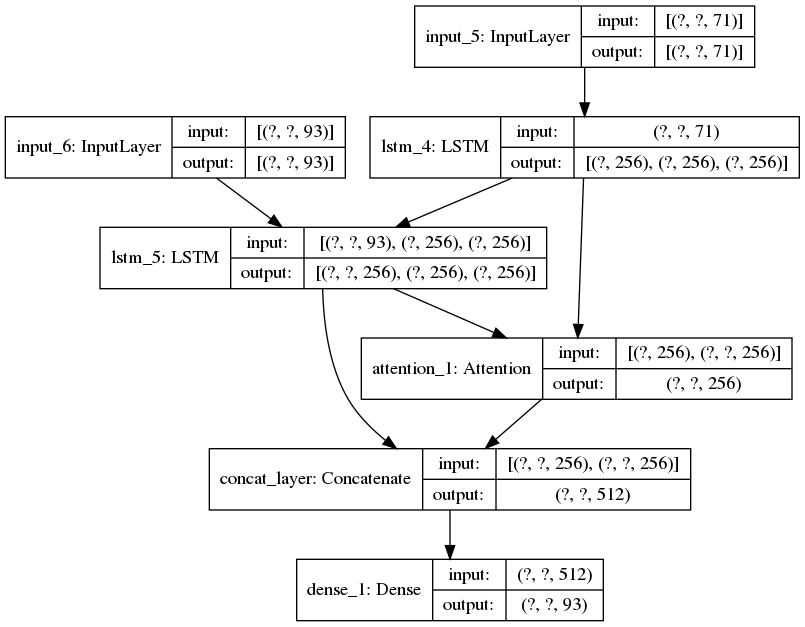

In [15]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [65]:
dropouts = 0.2
stacks = Seq2Seq_fit(dropouts)

Epoch 1/5
125/125 [==============================] - 11s 90ms/step - loss: 0.9134 - accuracy: 0.0649 - val_loss: 0.9209 - val_accuracy: 0.0973
Epoch 2/5
125/125 [==============================] - 11s 87ms/step - loss: 0.7287 - accuracy: 0.1131 - val_loss: 0.7439 - val_accuracy: 0.1383
Epoch 3/5
125/125 [==============================] - 11s 87ms/step - loss: 0.6180 - accuracy: 0.1375 - val_loss: 0.6706 - val_accuracy: 0.1595
Epoch 4/5
125/125 [==============================] - 11s 87ms/step - loss: 0.5604 - accuracy: 0.1521 - val_loss: 0.6209 - val_accuracy: 0.1716
Epoch 5/5
125/125 [==============================] - 11s 87ms/step - loss: 0.5213 - accuracy: 0.1635 - val_loss: 0.5865 - val_accuracy: 0.1828
Epoch 1/5
125/125 [==============================] - 11s 90ms/step - loss: 0.9129 - accuracy: 0.0650 - val_loss: 0.9128 - val_accuracy: 0.1010
Epoch 2/5
125/125 [==============================] - 11s 88ms/step - loss: 0.7303 - accuracy: 0.1126 - val_loss: 0.7681 - val_accuracy: 0.1328

In [66]:
stacks

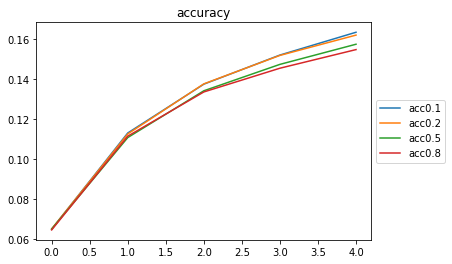

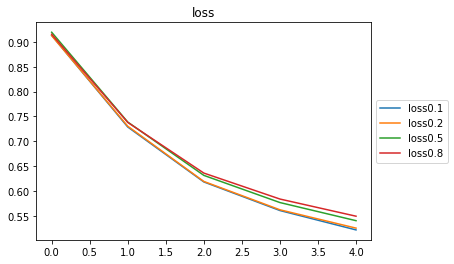

In [67]:
x = range(epochs)

for i in range(len(dropouts)):
    plt.plot(x, stacks[i].history['accuracy'], label=f"acc{dropouts[i]}")
plt.title("accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

for i in range(len(dropouts)):
    plt.plot(x, stacks[i].history['loss'], label=f"loss{dropouts[i]}")
# plt.plot(x, stacks[0].history['loss'], label="loss")
plt.title("loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Define sampling models

In [23]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [25]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [29]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [30]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Approne-moi.

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Apprecez-vous bien !

-
Input sentence: Run!
Decoded sentence: Apprecez-vous bien !

-
Input sentence: Who?
Decoded sentence: Qui a lais ?

-
Input sentence: Wow!
Decoded sentence: At-ce qu'il éta passe un bon domme ?

-
Input sentence: Fire!
Decoded sentence: Avant-il !

-
Input sentence: Help!
Decoded sentence: Allez Tom.

-
Input sentence: Jump.
Decoded sentence: Varez !

